# Create a Convolutional Neural Network using Python and libraries

The goal of this project is to create a CNN and learn it to recognize faces in photos.
We will use open-sources pictures libraries to train our model.
We will implement the following steps:
1. Import all needed libraries
2. Import images dataset, normalize it and shape it to fit the NN
3. Initialize the NN 
4. Train the NN with train dataset and check with validation dataset
5. Test the NN on test dataset

## Initialization

### 1.Import all needed libraries

We begin by initializing our programing environnement, importing every library needed.


In [55]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import seaborn as sb
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [4]:
!pip install -U skorch

Requirement already up-to-date: skorch in c:\users\mika-\.conda\envs\machinelearning\lib\site-packages (0.6.0)


In [106]:
from skorch import NeuralNetBinaryClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### 2. Import images dataset and shape it

Importing the dataset and normalizing it to fit into the NN

In [130]:
transform = transforms.Compose(
    [transforms.Resize((36,36)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

trainsetTotal = torchvision.datasets.ImageFolder(root='./start_deep/train_images',transform=transform)

trainloader = torch.utils.data.DataLoader(trainsetTotal, batch_size=64,
                                          shuffle=True)

trainingFeatures, trainingLabels = next(iter(trainloader))
trainingFeaturesNp = trainingFeatures.numpy()
trainingLabelsNp = trainingLabels.numpy()

X_train, X_val, y_train, y_val = train_test_split(
    trainingFeaturesNp, trainingLabelsNp, test_size=0.2, random_state=42, shuffle=True, stratify=trainingLabelsNp)

testset = torchvision.datasets.ImageFolder(root='./start_deep/test_images_custom',transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)
classes=('non-visage','visage')

print images

TypeError: Invalid shape (36, 36, 1) for image data

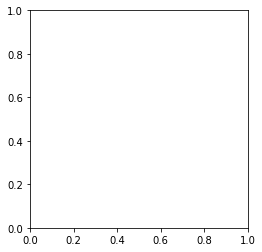

In [125]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
data = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(data[0][0:15], nrow = 16))
plt.imshow(np.transpose(X_train[0],(1, 2, 0)),interpolation='nearest')
plt.show()
# print labels
print(' '.join('%5s' % classes[data[1][j]] for j in range(15)))

### 2. Initialize the NN

we create our network and instanciate it using the torch.nn library

In [97]:
class CNN(nn.Module):
    
    #define the architecture of the NN
    def __init__(self):
        super(CNN,self).__init__()
        # 1 input chanel as images are in gray nuance
        # 6 output channels
        # 5x5 square convolution
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,20,5)
        self.conv3 = nn.Conv2d(20,30,5)
        #self.pool2 = nn.MaxPool2d(2,2)
        #ad affine operation y = Wx + b
        #correspond to the differents layers of the NN
        # with W = weight of the neurones and B = bias
        #self.fc1 = nn.Linear(20*5*5,200)
        self.fc1 = nn.Linear(30*8*8,200)
        self.fc2 = nn.Linear(200,80)
        self.fc3 = nn.Linear(80,1)
    
    #define the feed-forward algorithm for the NN
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        #x = self.pool2(F.relu(self.conv2(x)))
        x = (F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        #x = x.view(-1, 20*5*5)
        x = x.view(-1, 30*8*8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=-1)
        return x
        
cnn = CNN()

We create the torch wrapper in order to use the skitlearn functions

In [98]:
net = NeuralNetBinaryClassifier(
    module = CNN,
    #criterion= nn.CrossEntropyLoss,
    lr = 0.001,
    optimizer = optim.SGD,
    threshold=0.5,
    max_epochs = 4,
    batch_size =128,
    warm_start=True 
)

We now create:
* the criterion which will calculate the Loss function
    in this case we use CrossEntropyLoss: a combination of Softmax and Loss fct
* the optimizer which the algorithm used to compute the weight (grad desc, Adam...)
    in this case we use Stochastical Gradient Descent

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

### 4. Train and validate the NN

Train and validate the NN using skitlearn with cross validation

In [99]:
#trainingFeatures = trainingFeatures.view(-1,1)
net.fit(trainingFeatures,trainingLabels)

ValueError: Target size (torch.Size([51])) must be the same as input size (torch.Size([51, 1]))

In [96]:
for epoch in range(6): # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
       # imshow(torchvision.utils.make_grid(inputs[0:10]))
       # print(' '.join('%5s' % classes[labels[j]] for j in range(10)))
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward prop + optimizer
        outputs = cnn(trainingFeatures)
        loss = criterion(outputs, trainingLabels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i %100 == 99: #print every 100 mini-batches
            print('[%d, %5d loss: %.3f]' %
                 (epoch +1, i +1, running_loss / 100))
            running_loss = 0.0
            
print('Finished Training')
        

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at c:\n\pytorch_1559129895673\work\aten\src\thnn\generic/ClassNLLCriterion.c:93

We save our trained model

In [10]:
PATH = './CNN_2.pth'
torch.save(cnn.state_dict(), PATH)

In [34]:
cnn = CNN()
PATH = './CNN.pth'
cnn.load_state_dict(torch.load(PATH))

RuntimeError: Error(s) in loading state_dict for CNN:
	Missing key(s) in state_dict: "conv3.weight", "conv3.bias". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([6, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([6, 1, 5, 5]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([200, 500]) from checkpoint, the shape in current model is torch.Size([200, 1920]).

### 5. Test the NN on test dataset

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        imagesTest, labelsTest = data
        outputsTest = cnn(imagesTest)
        _,predicted = torch.max(outputsTest.data, 1)
        total += labelsTest.size(0)
        correct += (predicted == labelsTest).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 89 %
